In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Preparation

In [37]:
# Read in data and display first 5 rows
fn='../Data/INTERP_BGU.csv'
features = pd.read_csv(fn)
features.head()

,utvec,dv,err,temp,SM_EWT,date
0,2007.089722,-0.1144,0.1078,-1.94899,0.464541,2007-02-03
1,2007.092407,-0.1211,0.1080,-1.92494,0.464670,2007-02-04
2,2007.095093,-0.1260,0.1080,-1.82530,0.464805,2007-02-05
3,2007.097900,-0.1276,0.1075,-1.57670,0.464934,2007-02-06
4,2007.100586,-0.1357,0.1084,-1.36909,0.465069,2007-02-07


In [38]:
data_day=features.utvec
data_date=features.date
features=features.drop(columns=['utvec','date','err'])
features.head()

,dv,temp,SM_EWT
0,-0.1144,-1.94899,0.464541
1,-0.1211,-1.92494,0.464670
2,-0.1260,-1.82530,0.464805
3,-0.1276,-1.57670,0.464934
4,-0.1357,-1.36909,0.465069


In [39]:
features=features/np.max(np.abs(features))

In [40]:
# Descriptive statistics for each column
features.describe()

,dv,temp,SM_EWT
count,5675.000000,5675.000000,5675.000000
mean,0.000158,0.395811,0.017830
std,0.007947,0.344361,0.000973
min,-0.016374,-0.203928,0.016064
25%,-0.005907,0.082568,0.017270
50%,0.000031,0.355994,0.017659
75%,0.006004,0.724073,0.018226
max,0.018282,1.000000,0.021173


In [41]:
# One-hot encode the data using pandas get_dummies
features = pd.get_dummies(features)

# Display the first 5 rows of the last 12 columns
#features.iloc[:,:].head()

#### 2. Separating Features and Labels

labels in this case are the actual values of temperature

In [42]:
# Labels are the values we want to predict
labels = np.array(features['SM_EWT'])
# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop('SM_EWT', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

#### 3. Splitting the data randomly into Test and Training sets

random_state = 42 ensure the similarity of the split in each iteration

In [43]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [44]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (4256, 2)
Training Labels Shape: (4256,)
Testing Features Shape: (1419, 2)
Testing Labels Shape: (1419,)


#### 4. Setting up the model baseline

In [45]:
# The baseline predictions are the historical averages
baseline_preds = test_features[:, feature_list.index('dv')]
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  0.02


#### 5. Initializing a random forest regression model

In [46]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

#### 6. Assessing the performance of a model 

In [47]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 0.0


#### 7. Computing the Feature Importances

In [48]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: dv                   Importance: 0.52
Variable: temp                 Importance: 0.48


In [49]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)
# Extract the two most important features
important_indices = [feature_list.index('dv'), feature_list.index('temp')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

# Train the random forest
rf_most_important.fit(train_important, train_labels)



RandomForestRegressor(n_estimators=1000, random_state=42)

In [50]:
# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels)
# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2))
mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 0.0
Accuracy: 98.24 %.


In [51]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

# Pull out one tree from the forest
tree = rf.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# Write graph to a png file
graph.write_png('tree.png'); 

In [52]:
# Limit depth of tree to 2 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3, random_state=42)
rf_small.fit(train_features, train_labels)

# Extract the small tree
tree_small = rf_small.estimators_[5]

# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)

(graph, ) = pydot.graph_from_dot_file('small_tree.dot')

graph.write_png('small_tree.png');

### Visualizations

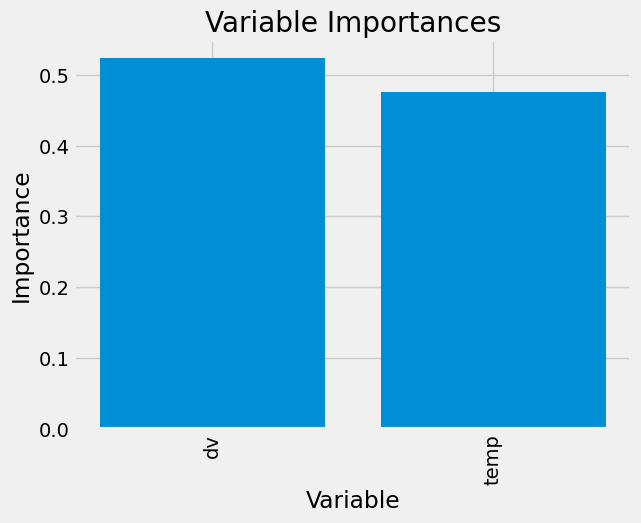

In [53]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [66]:
# Use datetime for creating date objects for plotting
import datetime
# List and then convert to datetime object

dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in data_date]
# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})


[-0.00442827 -0.00468762 -0.00487729 ...  0.01431447  0.01416738
  0.01406673]


In [65]:
# Dates of predictions
# Convert to datetime objects
print(len(predictions))
test_dates = data_date[:, ]

test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]
# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions})


1419


KeyError: 'key of type tuple not found and not a MultiIndex'

In [55]:

# Plot the actual values
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')
# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = 60); 
plt.legend()
# Graph labels
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');

ValueError: All arrays must be of the same length

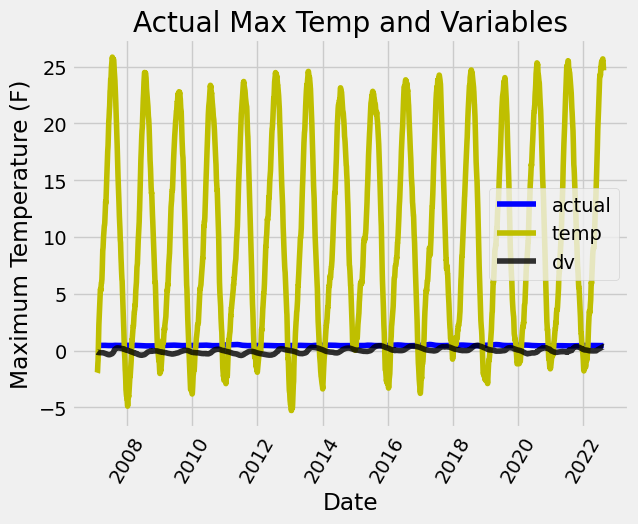

In [ ]:
# Make the data accessible for plotting
true_data['dv'] = features[:, feature_list.index('dv')]
true_data['temp'] = features[:, feature_list.index('temp')]
# Plot all the data as lines
plt.plot(true_data['date'], true_data['actual'], 'b-', label  = 'actual', alpha = 1.0)
#plt.plot(true_data['date'], true_data['temp'],    'y-', label  = 'temp', alpha = 1.0)
#plt.plot(true_data['date'], true_data['dv'], 'k-', label = 'dv', alpha = 0.8)

# Formatting plot
plt.legend(); plt.xticks(rotation = 60);
# Labels and title
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual Max Temp and Variables');